In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Scikit-Learn 官網作圖函式
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10,6))  #調整作圖大小
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


In [4]:
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None, seed_flag=False):
        params['random_state'] = seed
        
        if(seed_flag == False):
            params.pop('random_state')
            
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)

    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        return self.clf.fit(x,y).feature_importances_

In [5]:
#Out-of-Fold Predictions

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te) # partial index from x_train
        oof_test_skf[i, :] = clf.predict(x_test) # Row(n-Fold), Column(predict value)

    #oof_test[:] = oof_test_skf.mean(axis=0) #predict value average by column, then output 1-row, ntest columns
    #oof_test[:] = pd.DataFrame(oof_test_skf).mode(axis=0)[0]
    #oof_test[:] = np.median(oof_test_skf, axis=0)
    oof_test[:] = np.mean(oof_test_skf, axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1) #make sure return n-rows, 1-column shape.

### Load Dataset

In [6]:
train = pd.read_csv('input/train.csv', encoding = "utf-8", dtype = {'type': np.int32})
test = pd.read_csv('input/test.csv', encoding = "utf-8")

In [7]:
#把示範用的 type 4, 資料去除, 以免干擾建模
train = train[train['type']!=4]

In [8]:
from sklearn.model_selection import train_test_split

X = train[['花瓣寬度','花瓣長度','花萼寬度','花萼長度']]
y = train['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=100)

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

test_std = sc.transform(test[['花瓣寬度','花瓣長度','花萼寬度','花萼長度']])

### Model Building

In [10]:
from sklearn.cross_validation import KFold

NFOLDS = 5 # set folds for out-of-fold prediction
SEED = 0 # for reproducibility

ntrain = X_train_std.shape[0] # X.shape[0]
ntest = test_std.shape[0] # test.shape[0]

kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

C:\Users\admin\Anaconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
# Put in our parameters for said classifiers

# Decision Tree
dt_params = {
    'criterion':'gini',
    'max_depth':5
}

# KNN
knn_params = {
    'n_neighbors':5
}

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'criterion': 'gini',
    'max_depth': 4,
    #'min_samples_leaf': 2,
    'warm_start': True,
    'oob_score': True,
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 800,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 800,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 1.0,
    'probability': True
}

# Support Vector Classifier parameters 
svcr_params = {
    'kernel' : 'rbf',
    'C' : 1.0,
    'probability': True
}

# Bagging Classifier
bag_params = {
    'n_estimators' : 500,
    'oob_score': True
}

#XGBoost Classifier
xgbc_params = {
    'n_estimators': 500,
    'max_depth': 4,
    'learning_rate': 0.05,
    'nthread': -1
}

#Linear Discriminant Analysis
lda_params = {}

#Quadratic Discriminant Analysis
qda1_params = {
    'reg_param': 0.8,
    'tol': 0.00001
}

#Quadratic Discriminant Analysis
qda2_params = {
    'reg_param': 0.6,
    'tol': 0.0001
}

In [12]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

dt = SklearnHelper(clf=DecisionTreeClassifier, seed=SEED, params=dt_params, seed_flag=True)
knn = SklearnHelper(clf=KNeighborsClassifier, seed=SEED, params=knn_params)
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params, seed_flag=True)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params, seed_flag=True)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params, seed_flag=True)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params, seed_flag=True)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params, seed_flag=True)
svcr = SklearnHelper(clf=SVC, seed=SEED, params=svcr_params, seed_flag=True)
bag = SklearnHelper(clf=BaggingClassifier, seed=SEED, params=bag_params, seed_flag=True)
xgbc = SklearnHelper(clf=XGBClassifier, seed=SEED, params=xgbc_params)
lda = SklearnHelper(clf=LinearDiscriminantAnalysis, seed=SEED, params=lda_params)
qda1 = SklearnHelper(clf=QuadraticDiscriminantAnalysis, seed=SEED, params=qda1_params)
qda2 = SklearnHelper(clf=QuadraticDiscriminantAnalysis, seed=SEED, params=qda2_params)

In [13]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = y_train.ravel() 

#y.ravel()
#x_train = X.values # Creates an array of the train data
#x_test = test.values # Creats an array of the test data

#STD dataset:
x_train = X_train_std
x_test = test_std

In [14]:
# Create our OOF train and test predictions. These base results will be used as new features
dt_oof_train, dt_oof_test = get_oof(dt, x_train, y_train, x_test) # Decision Tree
knn_oof_train, knn_oof_test = get_oof(knn, x_train, y_train, x_test) # KNeighbors
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # SVM-l
svcr_oof_train, svcr_oof_test = get_oof(svcr, x_train, y_train, x_test) # SVM-r
bag_oof_train, bag_oof_test = get_oof(bag, x_train, y_train, x_test) # Bagging
xgbc_oof_train, xgbc_oof_test = get_oof(xgbc, x_train, y_train, x_test) # XGBoost
lda_oof_train, lda_oof_test = get_oof(lda, x_train, y_train, x_test) # Linear Discriminant Analysis
qda1_oof_train, qda1_oof_test = get_oof(qda1, x_train, y_train, x_test) # Quadratic Discriminant Analysis
qda2_oof_train, qda2_oof_test = get_oof(qda2, x_train, y_train, x_test) # Quadratic Discriminant Analysis

In [15]:
dt_features = dt.feature_importances(x_train,y_train)
##knn_features = knn.feature_importances(x_train,y_train)
rf_features = rf.feature_importances(x_train,y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train,y_train)
##svc_features = svc.feature_importances(x_train,y_train)
##svcr_features = svcr.feature_importances(x_train,y_train)
##bag_features = bag.feature_importances(x_train,y_train)
xgbc_features = xgbc.feature_importances(x_train,y_train)
##lda_features = lda.feature_importances(x_train,y_train)
##qda1_features = qda1.feature_importances(x_train,y_train)
##qda2_features = qda2.feature_importances(x_train,y_train)

[ 0.02732003  0.9285476   0.          0.04413236]
[ 0.38856997  0.47201879  0.02827505  0.1111362 ]
[ 0.41067952  0.39748945  0.06463249  0.11594853]
[ 0.4825  0.5175  0.      0.    ]
[ 0.05208262  0.05932165  0.01268544  0.01257696]
[ 0.43434343  0.30909091  0.11717172  0.13939394]


In [16]:
cols = X.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Decision Tree': dt_features,
     'Random Forest': rf_features,
     'Extra Trees': et_features,
     'AdaBoost': ada_features,
     'Gradient Boost': gb_features,
     'XGBoost': xgbc_features
    })

In [17]:
# Create the new column containing the average of values
feature_dataframe['mean'] = np.mean(feature_dataframe, axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe

,AdaBoost,Decision Tree,Extra Trees,Gradient Boost,Random Forest,XGBoost,features,mean
0,0.4825,0.027320,0.410680,0.052083,0.388570,0.434343,花瓣寬度,0.299249
1,0.5175,0.928548,0.397489,0.059322,0.472019,0.309091,花瓣長度,0.447328
2,0.0000,0.000000,0.064632,0.012685,0.028275,0.117172,花萼寬度,0.037127
3,0.0000,0.044132,0.115949,0.012577,0.111136,0.139394,花萼長度,0.070531


### First-Level Summary

In [18]:
#First-level output as new features
base_predictions_train = pd.DataFrame({
    'DecisionTree': dt_oof_train.ravel(),
    'KNeighbors': knn_oof_train.ravel(),
    'RandomForest': rf_oof_train.ravel(),
    'ExtraTrees': et_oof_train.ravel(),
    'AdaBoost': ada_oof_train.ravel(),
    'GradientBoost': gb_oof_train.ravel(),
    'SVM-l': svc_oof_train.ravel(),
    'SVM-r': svcr_oof_train.ravel(),
    'Bagging': bag_oof_train.ravel(),
    'XGBoost': xgbc_oof_train.ravel(),
    'LDA': lda_oof_train.ravel(),
    'QDA-1': qda1_oof_train.ravel(),
    'QDA-2': qda2_oof_train.ravel(),
    'Survived': y_train
    })
base_predictions_train.head()

,AdaBoost,Bagging,DecisionTree,ExtraTrees,GradientBoost,KNeighbors,LDA,QDA-1,QDA-2,RandomForest,SVM-l,SVM-r,Survived,XGBoost
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3,3.0
1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3,3.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0
3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0


In [19]:
x_train = np.concatenate(( #dt_oof_train, 
                           knn_oof_train, 
                           rf_oof_train,
                           et_oof_train, 
                           ada_oof_train, 
                           gb_oof_train, 
                           svc_oof_train, 
                           #svcr_oof_train,
                           bag_oof_train, 
                           xgbc_oof_train,
                           lda_oof_train,
                           #qda1_oof_train, 
                           qda2_oof_train
                         ), axis=1)
x_test = np.concatenate(( #dt_oof_test,
                          knn_oof_test, 
                          rf_oof_test,
                          et_oof_test,
                          ada_oof_test, 
                          gb_oof_test,
                          svc_oof_test, 
                          #svcr_oof_test,
                          bag_oof_test, 
                          xgbc_oof_test,
                          lda_oof_test,
                          #qda1_oof_test, 
                          qda2_oof_test
                        ), axis=1)

### Second Level Summary

### Level-2 XGBoost

In [20]:
#Second level learning model
import xgboost as xgb

l2_gbm = xgb.XGBClassifier(
         learning_rate = 0.05,
         n_estimators= 2000,
         max_depth= 4,
         #min_child_weight= 2,
         gamma=0.9,
         subsample=0.8,
         colsample_bytree=0.8,
         #scale_pos_weight=1,
         objective= 'binary:logistic',
         nthread= -1
).fit(x_train, y_train)

             precision    recall  f1-score   support

          1       1.00      1.00      1.00        26
          2       1.00      0.93      0.97        30
          3       0.93      1.00      0.97        28

avg / total       0.98      0.98      0.98        84



<module 'matplotlib.pyplot' from 'C:\\Users\\admin\\Anaconda3\\envs\\tensorflow_gpu\\lib\\site-packages\\matplotlib\\pyplot.py'>

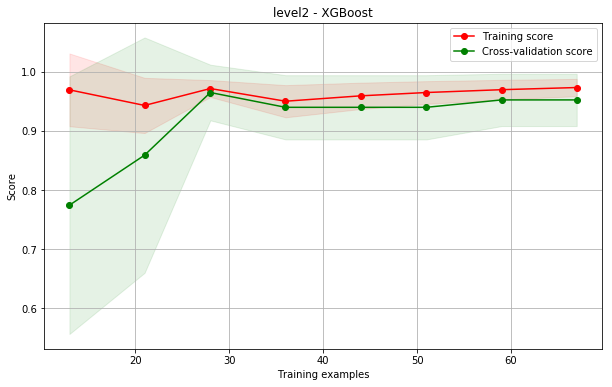

In [21]:
#level-2 CV: x_train, y_train

from sklearn import metrics
print(metrics.classification_report(y_train, l2_gbm.predict(x_train)))

from sklearn.model_selection import KFold
cv = KFold(n_splits=5, random_state=None, shuffle=True)
estimator = l2_gbm
plot_learning_curve(estimator, "level2 - XGBoost", x_train, y_train, cv=cv, train_sizes=np.linspace(0.2, 1.0, 8))

In [22]:
#level2 - XGB
#l2_gbm_pred = l2_gbm.predict(x_test)
metrics.precision_recall_fscore_support(y_train, l2_gbm.predict(x_train), average='weighted')

(0.97777777777777763, 0.97619047619047616, 0.97619047619047616, None)

### Level-2  Linear Discriminant Analysis

             precision    recall  f1-score   support

          1       1.00      1.00      1.00        26
          2       1.00      0.93      0.97        30
          3       0.93      1.00      0.97        28

avg / total       0.98      0.98      0.98        84



ValueError: Internal work array size computation failed: -10

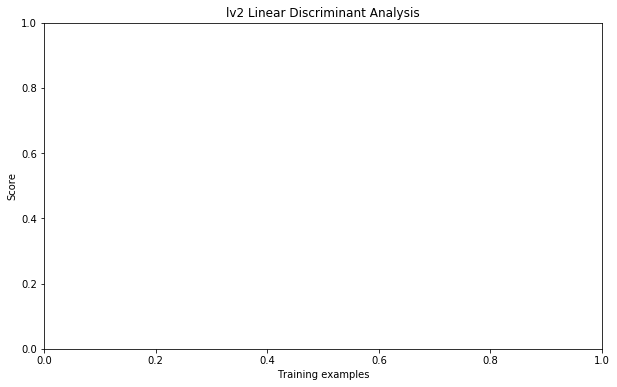

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
l2_lda = LinearDiscriminantAnalysis()
l2_lda.fit(x_train, y_train)
print(metrics.classification_report(y_train, l2_lda.predict(x_train)))

from sklearn.model_selection import KFold
cv = KFold(n_splits=5, random_state=None, shuffle=True)
estimator = l2_lda
plot_learning_curve(estimator, "lv2 Linear Discriminant Analysis", x_train, y_train, cv=cv, train_sizes=np.linspace(0.2, 1.0, 8))

In [24]:
#level2 - LDA
#l2_lda_pred = l2_lda.predict(x_test)
metrics.precision_recall_fscore_support(y_train, l2_lda.predict(x_train), average='weighted')

(0.97777777777777763, 0.97619047619047616, 0.97619047619047616, None)

### Level-2  Quadratic Discriminant Analysis

             precision    recall  f1-score   support

          1       1.00      1.00      1.00        26
          2       1.00      0.93      0.97        30
          3       0.93      1.00      0.97        28

avg / total       0.98      0.98      0.98        84



<module 'matplotlib.pyplot' from 'C:\\Users\\admin\\Anaconda3\\envs\\tensorflow_gpu\\lib\\site-packages\\matplotlib\\pyplot.py'>

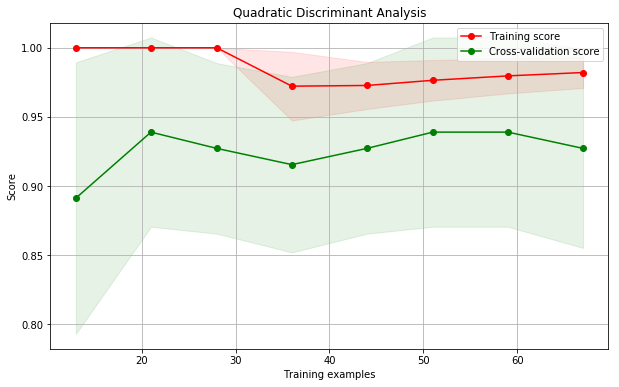

In [25]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
l2_qda = QuadraticDiscriminantAnalysis(reg_param=0.01, tol=0.001)
l2_qda.fit(x_train, y_train)
print(metrics.classification_report(y_train, l2_qda.predict(x_train)))

from sklearn.model_selection import KFold
cv = KFold(n_splits=5, random_state=None, shuffle=True)
estimator = l2_qda
plot_learning_curve(estimator, "Quadratic Discriminant Analysis", x_train, y_train, cv=cv, train_sizes=np.linspace(0.2, 1.0, 8))

In [26]:
#level2 - QDA
#l2_qda_pred = l2_qda.predict(x_test)
metrics.precision_recall_fscore_support(y_train, l2_qda.predict(x_train), average='weighted')

(0.97777777777777763, 0.97619047619047616, 0.97619047619047616, None)